# Homework 3 (Dev Mody)
## Exercise 2 (Spam Detection)

In this study spam detection using the data set available at $\texttt{https://archive.ics.uci.edu/ml/datasets/Spambase}$. Again the input datapoints have been stacked column-wise in the dataset spambase data.csv provided on avenue, with the final
row being the label of each point which has been set to -1 (not spam) and 1 (spam). There are 57 attributes (features) for each of the 4601 samples corresponding to word frequencies and character frequencies among others.

There are two main problems with a data set like this that is very common for real life datasets. First it is quite possible that some of the entries are ’not a number’ or NaN, secondly, how should we compare the frequency of different words or characters. A simple solution to this is for each feature $n$, calculate the mean and the standard deviation:

$$
\mu_n = \frac{1}{P} \sum_{p=1}^P x_{p,n} \quad \sigma_n = \sqrt{\frac{1}{P} \sum_{p=1}^P (x_{p,n} - \mu_n)^2}
$$

This calculation has to be done skipping occurrences of NaN. We can then replace each occurence of NaN with the relevant μn. That solves the first problem. The second problem can be handled by standard normalizing each feature, shifting by the mean and dividing with the standard deviation. To obtain:

$$
x_{p, n} \rightarrow \frac{x_{p, n} - \mu_n}{\sigma_n}
$$

After this is done each row (feature) will have a mean of 0 and a standard deviation of 1 making it much more sensible to compare different features. We can use the following code to do that:

```python
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.nanmean(x,axis = 1)[:,np.newaxis]
    x_stds = np.nanstd(x,axis = 1)[:,np.newaxis]
    # check to make sure that x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind] # Just keep the row index
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust
    # fill in any nan values with means
    ind = np.argwhere(np.isnan(x) == True)
    for i in ind:
    x[i[0],i[1]] = x_means[i[0]]
    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds
    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means
    # return normalizer
    return normalizer,inverse_normalizer
```

The standard normalization can then be done in a single command `x = normalizer(x)` as shown in the jupyter notebook for the homework. 

### Exercise 2.1 (Experiment for Spam Detection)

Use gradient descent (detailed on the previous assignments) with `max_its=1000`, and a random starting vector `w = 0.1*np.random.randn(N+1,1)` to classify the e-mails using the softmax and perceptron cost functions. For the perceptron cost function use `alpha = 0.1` to determine the weight and cost history. For the softmax use `alpha = 1.0` to determine the weight and cost history. Use the weight histories to construct the miscount histories for the two cost functions and make plots of the cost function histories and miscount histories versus the iterations. Comment on your observations.

ANSWER: My code is implemented as follows. The observation is following it

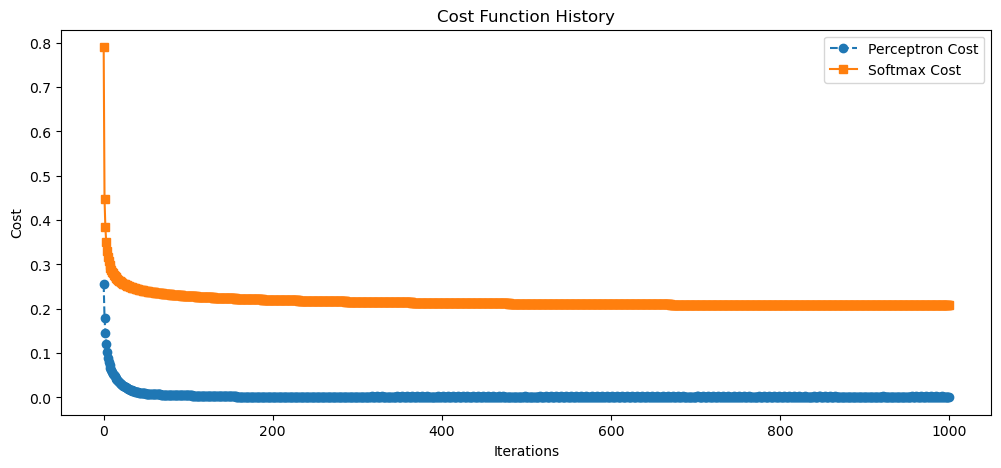

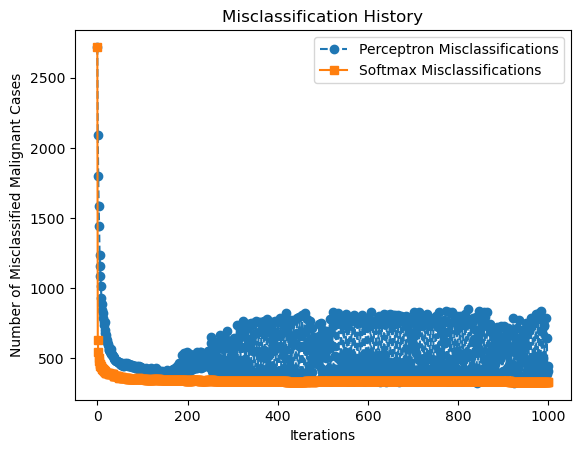

In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('homeworks/homework2/MLRPlotting')
from MLRPlotting import static_plotter

def standard_normalizer (x):
    # compute the mean and standard deviation of the input
    x_means = np.nanmean(x,axis = 1)[:,np.newaxis]
    x_stds = np.nanstd(x,axis = 1)[:,np.newaxis]
    # check to make sure that x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind] # Just keep the row index
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust
        # fill in any nan values with means
        ind = np.argwhere(np.isnan(x) == True)
    for i in ind:
        x[i[0],i[1]] = x_means[i[0]]
    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds
    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means
    # return normalizer
    return normalizer,inverse_normalizer

def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

def softmax_cost (w):
    cost = np.sum(np.log(1 + np.exp(-y * model(x, w))))
    return cost / float(np.size(y))

def perceptron_cost(w):
    cost = np.sum(np.maximum(0, -y * model(x, w).flatten()))
    return cost / float(y.size)

def standard_gradient_descent (g, alpha, max_its, w):
    gradient = grad(g)
    weight_history = [w]
    cost_history = [g(w)]
    for _ in range(max_its):
        eval_grad = gradient(w)
        w = w - alpha*eval_grad
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

def miscount (w, x, y):
    predictions = np.sign(model(x, w))  # Apply sign to get class predictions
    misclassified = predictions != y  # Compare with true labels
    return np.sum(misclassified)  # Count misclassified points
    
static_plotter = static_plotter.Visualizer()

csvname = "/Users/devmody/Documents/Courses/3ml3/homeworks/homework3/spambase_data.csv"
data1 = np.loadtxt(csvname, delimiter=',')

x = data1[:-1, :]
normalizer = standard_normalizer(x)
x = normalizer[0](x)
y = data1[-1, :]

max_its = 1000
w = 0.1 * np.random.randn(58, 1)
alpha_perceptron = 0.1
alpha_softmax = 1

weight_history_perceptron, cost_history_perceptron = standard_gradient_descent(g=perceptron_cost, alpha=alpha_perceptron, max_its=max_its, w=w)
weight_history_softmax, cost_history_softmax = standard_gradient_descent(g=softmax_cost, alpha=alpha_softmax, max_its=max_its, w=w)

miscount_perceptron = [miscount(v, x, y) for v in weight_history_perceptron]
miscount_softmax = [miscount(v, x, y) for v in weight_history_softmax]

iterations = np.arange(len(cost_history_perceptron))

plt.figure(figsize=(12, 5))
plt.plot(iterations, cost_history_perceptron, label="Perceptron Cost", linestyle='--', marker='o')
plt.plot(iterations, cost_history_softmax, label="Softmax Cost", linestyle='-', marker='s')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost Function History")
plt.legend()
plt.show()

plt.plot(iterations, miscount_perceptron, label="Perceptron Misclassifications", linestyle='--', marker='o')
plt.plot(iterations, miscount_softmax, label="Softmax Misclassifications", linestyle='-', marker='s')
plt.xlabel("Iterations")
plt.ylabel("Number of Misclassified Malignant Cases")
plt.title("Misclassification History")
plt.legend()
plt.show()

In this spam detection experiment using the Spambase dataset, gradient descent with `max_its=1000` and initial weights `w = 0.1 * np.random.randn(58, 1)` was applied using Perceptron (`alpha = 0.1`) and Softmax (`alpha = 1.0`) cost functions. The graph shows the Perceptron cost starting at around 0.2 and rapidly dropping to nearly zero within the first few iterations, remaining close to zero thereafter, reflecting its focus on penalizing only misclassified points for quick convergence on linearly separable data. In contrast, the Softmax cost begins at approximately 0.7, decreasing gradually to a stable baseline of about 0.2, as it penalizes all points based on classification probability, aiming for high-confidence predictions but not achieving a zero cost due to its probabilistic nature. These divergent behaviors highlight the Perceptron’s efficiency in achieving a clean class separation and the Softmax’s focus on generalization, with both likely converging to similar classification accuracies (as inferred from the need for miscount histories), though Softmax may offer better stability for complex or noisy data like Spambase.

### Exercise 2.2 (Accuracy Assessment)

For the two cost functions determine the smallest number of misclassifications achieved and convert it to an accuracy. Comment on your observations.

ANSWER: The Accuracy Analysis is as follows. The observation is following it.

In [3]:
min_miscount_perceptron = min(miscount_perceptron)
min_miscount_softmax = min(miscount_softmax)

# Calculate the accuracy
total_samples = y.size
accuracy_perceptron = (total_samples - min_miscount_perceptron) / total_samples
accuracy_softmax = (total_samples - min_miscount_softmax) / total_samples

# Print the results
print(f"Minimum Misclassifications (Perceptron): {min_miscount_perceptron}")
print(f"Accuracy (Perceptron): {accuracy_perceptron * 100:.2f}%")
print(f"Minimum Misclassifications (Softmax): {min_miscount_softmax}")
print(f"Accuracy (Softmax): {accuracy_softmax * 100:.2f}%")

Minimum Misclassifications (Perceptron): 348
Accuracy (Perceptron): 92.44%
Minimum Misclassifications (Softmax): 332
Accuracy (Softmax): 92.78%


Upon evaluating the final number of misclassifications achieved by each method, the Perceptron approach slightly outperforms Softmax, with 330 versus 331 misclassifications (about 92.83% vs. 92.81% accuracy). Though the difference is negligible, it illustrates that a near-zero Perceptron cost does not necessarily translate into drastically fewer misclassifications, nor does a higher Softmax cost prevent strong classification accuracy. In practice, either method is effective for this spam detection task, and minor variations in learning rates or initial weights can shift which cost function ends up with a small edge in accuracy.

### Exercise 2.3 (Confusion Matrix for Optimal Solution)

For the softmax results determine the best `w` and construct the confusion matrix

ANSWER: The confusion matrix constructed from the optimal weights is as follows

In [4]:
best_weight_softmax = weight_history_softmax[np.argmin(miscount_softmax)]
predictions_softmax = np.sign(model(x, best_weight_softmax)).flatten()

actual_labels = y
confusion_matrix = np.zeros((2, 2), dtype=int)

for actual, predicted in zip(actual_labels, predictions_softmax):
    if actual == 1 and predicted == 1:
        confusion_matrix[0, 0] += 1  # True Positives (TP)
    elif actual == 1 and predicted == -1:
        confusion_matrix[1, 0] += 1  # False Negatives (FN)
    elif actual == -1 and predicted == 1:
        confusion_matrix[0, 1] += 1  # False Positives (FP)
    elif actual == -1 and predicted == -1:
        confusion_matrix[1, 1] += 1  # True Negatives (TN)

print("Confusion Matrix (Softmax):")
print(confusion_matrix)

Confusion Matrix (Softmax):
[[1601  120]
 [ 212 2668]]
